In [5]:
import math
import random
#Benötigte Pakete

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 

import matplotlib.mlab as mlab
import numpy as np
import cmath

from numpy import linalg as LA
import scipy
from scipy import spatial
import time
from scipy import stats
#import tables

import os
#import h5py

from matplotlib import animation
import matplotlib
from scipy.optimize import curve_fit
from matplotlib import rc
import os

import gc
import sys
gc.enable()
import copy

from mpl_toolkits import mplot3d

### Erzeugung

Function whicht produces the requiered configuration of atoms

In [13]:
def to_ind(coord):
    x_shifted = coord[0]+radius
    y_shifted = np.abs(coord[1]-radius)

    j = np.floor(x_shifted/(size_square))
    i = np.floor(y_shifted/(size_square))
    return int(i),int(j)

def to_coord(ind):
    x = ind[1]*size_square
    y = ind[0]*size_square
    
    x_shifted = x -radius
    y_shifted = radius - y
 
    return [x_shifted, y_shifted]


def get_atoms_near(punkt, counting_atoms):
    m,n = to_ind(punkt[0])
    atoms_near=[]
    atoms_near.extend(counting_atoms[m][n][1])

    try:
        atoms_near.extend(counting_atoms[m+1][n][1])             
        atoms_near.extend(counting_atoms[m+1][n+1][1])       
        atoms_near.extend(counting_atoms[m][n+1][1])
        atoms_near.extend(counting_atoms[m-1][n-1][1])        
        atoms_near.extend(counting_atoms[m-1][n][1])
        atoms_near.extend(counting_atoms[m-1][n+1][1])
        atoms_near.extend(counting_atoms[m][n-1][1])
        atoms_near.extend(counting_atoms[m+1][n-1][1])
        return atoms_near
    except IndexError:
        if m+1<number_squares:
            atoms_near.extend(counting_atoms[m+1][n][1])
            if n+1< number_squares:
                atoms_near.extend(counting_atoms[m+1][n+1][1])
        if n+1<number_squares:
            atoms_near.extend(counting_atoms[m][n+1][1])

        if (m-1)>=0 and (n-1)>=0: 
            atoms_near.extend(counting_atoms[m-1][n-1][1])
        if (m-1)>=0: 
            atoms_near.extend(counting_atoms[m-1][n][1])
            if n+1<number_squares:
                atoms_near.extend(counting_atoms[m-1][n+1][1])
        if (n-1)>=0: 
            atoms_near.extend(counting_atoms[m][n-1][1])
            if m+1<number_squares:
                atoms_near.extend(counting_atoms[m+1][n-1][1])
    return atoms_near


def produce_atoms(number_atoms, a, r_b):
    global size_square
    global number_squares
    size_square = 2*r_b #np.sqrt(density*50*r_b**2)   #2*r_b   #wähle size_square so, dass 50 atome drin sind.
    #size_square gerade klein genug um 8 Felder außen rum zu benutzen um abzugleichen
    number_squares= int(a*2/size_square)
    size_square = a*2/number_squares


    A=np.pi*a*a
    
    
    counting_atoms = [[[0,[]] for i in range(number_squares)] for i in range(number_squares)]
        
    atoms = [[0,0]]
    m,n = to_ind([0,0])
    counting_atoms[m][n][0]+=1
    counting_atoms[m][n][1] = [[0,0]]
    
        
    for i in range(number_atoms-len(atoms)):
        r=(a-r_b)*np.sqrt(random.uniform(0,1))
        theta=random.uniform(0,1)*2*np.pi
        x,y=r * np.cos(theta), r * np.sin(theta)
        punkt = np.array([[x,y]]) 
        gesetzt= False
        
        while (gesetzt==False):
            gesetzt=True

            atoms_near = get_atoms_near(punkt, counting_atoms)

            if atoms_near:
                if ((np.min(scipy.spatial.distance.cdist(atoms_near, punkt, metric='euclidean')))<(2*r_b)):
                    r=a*np.sqrt(random.uniform(0,1))
                    theta=random.uniform(0,1)*2*np.pi
                    x,y=r * np.cos(theta), r * np.sin(theta)
                    punkt = np.array([[x,y]]) 
                    gesetzt=False
                            
                    
        atoms.append(punkt[0])
        m,n = to_ind(punkt[0])
        counting_atoms[m][n][0]+=1
        counting_atoms[m][n][1].append(punkt[0].tolist())

    return np.round(atoms,4)

### Hamiltonian

Function that builds Hamiltonian and returns eigenvalues and eigenvectors by setting them as global.

In [4]:
def eigenvektoren(atoms):
    
#Distance + Hamiltonian-------------------------------------------------------------------------------------
    global distance_matrix
    global abstand_ursprung
    H = np.zeros((number_atoms,number_atoms),dtype=np.float16)
    distance_matrix = np.zeros((number_atoms,number_atoms),dtype=np.float16)
    abstand_ursprung= np.zeros(number_atoms, dtype=np.float16)
    
    distance_matrix= scipy.spatial.distance.cdist(atoms, atoms, metric='euclidean')
    abstand_ursprung = copy.copy(distance_matrix[:,angeregt])
    np.fill_diagonal(distance_matrix,1)
    H=np.divide(coupling_constant,np.power(distance_matrix,3))
    np.fill_diagonal(distance_matrix,0)
    np.fill_diagonal(H,0)
    
    
#Linearisierung---------------------------------------------------------------------------------------------
    global eigenvalues
    global eigenvectors
    eigenvalues=np.zeros(number_atoms,dtype=np.float16)
   
    eigenvectors=np.zeros((number_atoms,number_atoms),dtype=np.float16)
    eigenvalues, eigenvectors = LA.eigh(H)
 
    return 

### Infinity Berechnungen

Calcultation of the transport properties out of the steady state probability distribution for t-> infinity.
density, correlation, r_1, r_2, ipr_inf...

In [5]:
def trans_prop():    
    x=np.arange(0,radius,1)
    
    #infinity_probability----------------------------------------------------------------------------------
    p_infinity=np.dot(np.square(eigenvectors[0]),np.square(eigenvectors.transpose()))
    
    #infinity_accumulation --------------------------------------------------------------------------------
    n_ursprung_inf=[]
      
    for i in x:
        n_ursprung_inf.append(np.sum(p_infinity[(i<=abstand_ursprung)]))
    
    #density + correlation-----------------------------------------------------------------------------------
    density_rings_inf=[]
    correlation = []
    for klein in np.arange(0,radius,d_r):
        
        index = np.argwhere((klein<=abstand_ursprung)& (abstand_ursprung<klein+d_r))
        laenge= len(index)
        if laenge==0:
            density_rings_inf.append(0)
        else:
            density_rings_inf.append(np.sum(p_infinity[index])/laenge)
            
        flaeche= np.pi*((klein+d_r)**2-klein**2)
        indices=np.where((distance_matrix!=0) & (klein<distance_matrix))#& (distance_matrix<=klein+d_r))    
        correlation.append(np.sum(p_infinity[indices[0]]*p_infinity[indices[1]]))
    
    
    #distribution_width---------------------------------------------------------------------------------    
    innen=0
    distribution_width_inf=0
    tmp=copy.copy(abstand_ursprung)
    while innen<0.9:
        minimum= np.argmin(tmp)
        distribution_width_inf= abstand_ursprung[minimum]
        innen+= p_infinity[minimum]     
        tmp[minimum]=math.inf 
     
    #deviation---------------------------------------------------------------------------------------------
    r_2_inf=np.dot(p_infinity,np.power(abstand_ursprung,2)[:,None])
    r_1_inf=np.dot(p_infinity,abstand_ursprung[:,None])
    deviation_inf=np.sqrt(np.subtract(r_2_inf,np.square(r_1_inf)))
    
    #ipr---------------------------------------------------------------------------------------------------
    p_infinity_g=np.dot(np.power(eigenvectors[0],4),np.power(eigenvectors.transpose(),4))

    ipr_inf = 1/(np.sum(2*p_infinity**2-p_infinity_g))
   
    
    return np.array(correlation),np.array(density_rings_inf), distribution_width_inf, r_2_inf, r_1_inf, deviation_inf, ipr_inf, np.array(n_ursprung_inf)

### Messungen

In [6]:
#1. Messung ...............................................................................................
r_b=5
radius_1       = 600
anzahl_1       = np.array([72,   144,  360,  720, 1440,2160,2880,3600,4320,5040,5760,6480,7200])
iteration_1    = np.array([50000,30000,20000,7000,2000,800, 500, 200, 100, 100,  100, 70,  24])


#2. Messung ...............................................................................................
r_b = 5
radius=500
anzahl=     np.array([50,   100,  250,  500,  1000,1500,2000,2500,3000,3500,4000,4500,5000])
iteration = np.array([50000,40000,30000,15000,7000,3000,1500,1000, 800, 600, 400, 250, 120])

#3. Messung ...............................................................................................
r_b = 5
radius=400
anzahl =    np.array([32,   64,   160,  320,  640,  960, 1280,1600,1920,2240,2560,2880,3200])
iteration = np.array([50000,40000,30000,20000,10000,7000,2000,1000,800, 600, 400, 300, 200])

# Main - Transport properties

In [6]:
global number_atoms

r_b = 5              
      
coupling_constant= 3*10**9 

global d_r
d_r=12
global angeregt
angeregt=0


r_b = 5
radius=500
#anzahl=np.array([        98,  196,  490, 980, 1960, 2940, 3920, 4900, 5880, 6860, 7840, 8820, 9800])
#iteration = np.array([50000,30000,20000,6000, 5000,2000, 1000,  500,  300,  150, 70,   50, 30])

anzahl=np.array([600,700])
iteration = np.array([3,7])

#### Ordner erstellen

The following cell creates the needed folders for the atom configuration and the folder for the results.
It is also measured how many files of the atom configurations are available.

In [7]:
speicher_atome=np.zeros(len(anzahl),int)

s=0
for number_atoms in anzahl:
    density = number_atoms*r_b**2/(radius**2)
    folder_a= "files/atoms/density_"+str(np.round(density,3))+"/atoms_"+str(number_atoms)+"_"+str(int(radius))
   
    if number_atoms>500:
        if not os.path.exists("/home/jp/Dokumente/Bachelorarbeit/Überarbeitung/"+folder_a):
            os.makedirs("/home/jp/Dokumente/Bachelorarbeit/Überarbeitung/"+folder_a)
            print(folder_a +" erstellt")

        path, dirs, files = next(os.walk(folder_a))
        speicher_atome[s] = len(files)
    
    print("# files in Ordner atom_"+str(number_atoms)+"_"+str(int(radius))+": ", speicher_atome[s])
    s+=1

    folder_trans="files/infinity/density_"+str(np.round(density,3))+"/transport"
    if not os.path.exists("/home/jp/Dokumente/Bachelorarbeit/Überarbeitung/"+folder_trans):
        os.makedirs("/home/jp/Dokumente/Bachelorarbeit/Überarbeitung/"+folder_trans)
        print(folder_trans +" erstellt")
    
print("Anzahl:          ",anzahl)
print("speicher_atome:  ",speicher_atome)
print("Dichte:          ",(anzahl*r_b**2)/(radius**2))

files/atoms/density_0.06/atoms_600_500 erstellt
# files in Ordner atom_600_500:  0
files/infinity/density_0.06/transport erstellt
files/atoms/density_0.07/atoms_700_500 erstellt
# files in Ordner atom_700_500:  0
files/infinity/density_0.07/transport erstellt
Anzahl:           [600 700]
speicher_atome:   [0 0]
Dichte:           [0.06 0.07]


In [13]:
#iteration = np.array([2000,2000,2000,1000,1000,500,200,150,100, 50, 30, 20, 10])
print(len(iteration))
print(iteration)

2
[3 7]


### Mittelung

The following cell iterates over the array anzahl and repeat this regarding to array iterations.
If the number_atoms is <500 no new file will be saved.
The average for every quantitie is done and also the variance is calculated and saved in the folder transport.

In [14]:
z=0
i=0
start1=time.time()
gebrauchte_zeit=np.zeros(len(anzahl))

for number_atoms in anzahl:
    start2=time.time()
    density=(number_atoms*r_b**2)/(radius**2)
    folder_a= "/home/jp/Dokumente/Bachelorarbeit/Überarbeitung/files/atoms/density_"+str(np.round(density,3))+"/atoms_"+str(number_atoms)+"_"+str(int(radius))
    print(number_atoms)
    save_nr = 0
    
    if number_atoms>500:
        if save_nr<speicher_atome[z]:
            atoms = open(folder_a+"/atoms"+str(number_atoms)+"_"+str(int(radius))+"_"+str(save_nr)+".npy","rb")
            atoms_array= np.load(atoms)
            atoms.close()
        else:
            atoms = open(folder_a+"/atoms"+str(number_atoms)+"_"+str(int(radius))+"_"+str(save_nr)+".npy","wb")
            atoms_array = produce_atoms(number_atoms, radius, r_b)
            np.save(atoms,atoms_array)
            atoms.close()
    else:
        atoms_array = produce_atoms(number_atoms, radius, r_b)
            
    eigenvektoren(atoms_array)
    
    correlation, density_rings_inf, distribution_width_inf, r_2_inf, r_1_inf, deviation_inf, ipr_inf, n_ursprung_inf = trans_prop()

    
    correlation_S            = 0 
    density_rings_inf_S      = 0          
    ipr_inf_S                = 0
    n_ursprung_inf_S         = 0       
    distribution_width_inf_S = 0               
    deviation_inf_S          = 0      
    r_1_inf_S                = 0
    r_2_inf_S                = 0

    
    save_nr+=1
    for i in range(0,iteration[z]-1):
    
        print("Iteration:", i+1)

        if number_atoms>500:
            if save_nr<speicher_atome[z]:
                atoms = open(folder_a+"/atoms"+str(number_atoms)+"_"+str(int(radius))+"_"+str(save_nr)+".npy","rb")
                atoms_array= np.load(atoms)
                atoms.close()
            else:
                atoms = open(folder_a+"/atoms"+str(number_atoms)+"_"+str(int(radius))+"_"+str(save_nr)+".npy","wb")
                atoms_array = produce_atoms(number_atoms, radius, r_b)
                np.save(atoms,atoms_array)
                atoms.close()
        else:
            atoms_array = produce_atoms(number_atoms, radius, r_b)
        
        
        eigenvektoren(atoms_array)
        correlation_tmp,density_rings_inf_tmp, distribution_width_inf_tmp, r_2_inf_tmp, r_1_inf_tmp, deviation_inf_tmp, ipr_inf_tmp, n_ursprung_inf_tmp = trans_prop()
      
        correlation_prev                 =  correlation
        density_rings_inf_prev           =  density_rings_inf        
        ipr_inf_prev                     =  ipr_inf
        n_ursprung_inf_prev              =  n_ursprung_inf     
        distribution_width_inf_prev      =  distribution_width_inf             
        deviation_inf_prev               =  deviation_inf    
        r_1_inf_prev                     =  r_1_inf
        r_2_inf_prev                     =  r_2_inf
        
        correlation                      = (correlation*(i+1)+correlation_tmp)/(i+2)
        density_rings_inf                = (density_rings_inf*(i+1)+density_rings_inf_tmp)/(i+2)
        ipr_inf                          = (ipr_inf*(i+1)+ipr_inf_tmp)/(i+2)
        n_ursprung_inf                   = (n_ursprung_inf*(i+1)+n_ursprung_inf_tmp)/(i+2)
        distribution_width_inf           = (distribution_width_inf*(i+1)+distribution_width_inf_tmp)/(i+2)
        deviation_inf                    = (deviation_inf*(i+1)+deviation_inf_tmp)/(i+2)
        r_1_inf                          = (r_1_inf*(i+1)+r_1_inf_tmp)/(i+2)
        r_2_inf                          = (r_2_inf*(i+1)+r_2_inf_tmp)/(i+2)
        
        correlation_S                    += (correlation_tmp-correlation)*(correlation_tmp-correlation_prev) 
        density_rings_inf_S              += (density_rings_inf_tmp-density_rings_inf)*(density_rings_inf_tmp-density_rings_inf_prev)                 
        ipr_inf_S                        += (ipr_inf_tmp-ipr_inf)*(ipr_inf_tmp-ipr_inf_prev)       
        n_ursprung_inf_S                 += (n_ursprung_inf_tmp-n_ursprung_inf)*(n_ursprung_inf_tmp-n_ursprung_inf_prev)              
        distribution_width_inf_S         += (distribution_width_inf_tmp-distribution_width_inf)*(distribution_width_inf_tmp-distribution_width_inf_prev)                     
        deviation_inf_S                  += (deviation_inf_tmp-deviation_inf)*(deviation_inf_tmp-deviation_inf_prev)             
        r_1_inf_S                        += (r_1_inf_tmp-r_1_inf)*(r_1_inf_tmp-r_1_inf_prev)       
        r_2_inf_S                        += (r_2_inf_tmp-r_2_inf)*(r_2_inf_tmp-r_2_inf_prev)       
        

        save_nr+=1
    
    
    correlation_S             =  np.sqrt(correlation_S/iteration[z]) 
    density_rings_inf_S       =  np.sqrt(density_rings_inf_S/iteration[z])  
    ipr_inf_S                 =  np.sqrt(ipr_inf_S/iteration[z])   
    n_ursprung_inf_S          =  np.sqrt(n_ursprung_inf_S/iteration[z])  
    distribution_width_inf_S  =  np.sqrt(distribution_width_inf_S/iteration[z])    
    deviation_inf_S           =  np.sqrt(deviation_inf_S/iteration[z])     
    r_1_inf_S                 =  np.sqrt(r_1_inf_S/iteration[z]) 
    r_2_inf_S                 =  np.sqrt(r_2_inf_S/iteration[z])  
    
    gebrauchte_zeit[z]=(time.time()-start2)
    print(gebrauchte_zeit[z])
    z+=1

    data = open("/home/jp/Dokumente/Bachelorarbeit/Überarbeitung/files/infinity/density_"+str(np.round(density,3))+"/transport/inf_"+str(number_atoms)+"_"+str(int(radius))+".npy","wb")
    np.save(data,density_rings_inf)
    np.save(data,ipr_inf)
    np.save(data,n_ursprung_inf)
    np.save(data,distribution_width_inf)
    np.save(data,deviation_inf)
    np.save(data,r_1_inf)
    np.save(data,r_2_inf)
    
    np.save(data,density_rings_inf_S)
    np.save(data,ipr_inf_S)
    np.save(data,n_ursprung_inf_S)
    np.save(data,distribution_width_inf_S)
    np.save(data,deviation_inf_S)
    np.save(data,r_1_inf_S)
    np.save(data,r_2_inf_S)
    np.save(data,correlation)
    np.save(data,correlation_S)
    
    data.close()
    
    
    
print(gebrauchte_zeit)
print(time.time()-start1)

600
Iteration: 1
Iteration: 2
1.8000752925872803
700
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
5.245669603347778
[1.80007529 5.2456696 ]
7.061927556991577


In [15]:
print(np.round(gebrauchte_zeit/60/60,1))

[0. 0.]


# Eigenstates

In [8]:
def eigenstate():
    
    #eigenstates----------------------------------------------------------------------------------------
    p_eigenstates = np.square(np.absolute(eigenvectors))
    
    #inverse participation ratio -------------------------------------------------------------------------
    ipr_2=[]
    for i in range(number_atoms):    
        ipr_2.append(1/np.sum(p_eigenstates[:,i]**2)) 
        
        
    # ratio -----------------------------------------------------------------------------------------------  
    ratio = np.zeros([number_atoms])
    for n in range(1,number_atoms-1):
        delta_n = eigenvalues[n+1]-eigenvalues[n]
        delta_n_1 = eigenvalues[n]-eigenvalues[n-1]
        ratio[n] = np.min([delta_n,delta_n_1])/np.max([delta_n,delta_n_1])   
    
    
    return np.array(ipr_2), np.array(ratio) 

In [9]:
def one_eigenstate(eigenstate,dr_corr):
   
    #eigenstate----------------------------------------------------------------------------------------
    p_eigenstate =  np.square(np.absolute(eigenvectors[:,eigenstate]))
  
    
    #schwerpunkt------------------------------------------------------------------------------------------
    schwerpunkt= np.dot(p_eigenstate,atoms_array) 
    distanz= scipy.spatial.distance.cdist([schwerpunkt],atoms_array, metric='euclidean')[0]
 
    #correlation
    #radial density from Schwerpunkt aus des eigenstates ------------------------------------------------
    
    correlation=[]
    density_eig=[]
    max_abstand=np.max(distanz)
    
    for klein in range(0,int(radius*2),dr_corr):
        indices=np.where((distance_matrix!=0) & (klein<distance_matrix))
        correlation.append(np.sum(p_eigenstate[indices[0]]*p_eigenstate[indices[1]]))
        
        index = np.argwhere((klein<=distanz) & (distanz<klein+d_r))
        laenge= len(index)
        
        if laenge==0:
            density_eig.append(0)
        else:
            density_eig.append(np.sum(p_eigenstate[index])/len(index))
   
 
    return np.array(density_eig), np.array(correlation)

### Main - Eigenstates properties

In [12]:
numbers= np.array([100,500,1000,1500])
dens=np.array([0.05,0.25,0.45])
radius = np.sqrt(numbers/dens*r_b**2)
print(numbers)
print(radius)

z= pow(numbers/(np.pi*radius*radius), -1.0/2.0)
print("Mittlerer abstand:",z)
print()

ValueError: operands could not be broadcast together with shapes (4,) (3,) 

In [13]:
global number_atoms
r_b = 5              
  
coupling_constant= 3*10**9 

global d_r
d_r=12


global angeregt
angeregt=0


dr_corr=5
#dens= 0.25
#number_atoms=1000
#radius = np.sqrt(number_atoms*r_b**2/dens)
radius=300

anzahl=np.array([100,500,1000,1500])
#iteration = np.array([2000,2000,1500,1000])
iteration = np.array([2000,2000,1000,500])

#dens=(anzahl*r_b**2)/(radius**2)
dens=np.array([0.05])
radius=np.sqrt(anzahl*r_b**2/dens)
print(dens)
print(radius)

dens=0.25
for number_atoms in anzahl:
    #density = number_atoms*r_b**2/(radius**2)
    radius=np.sqrt(number_atoms*r_b**2/dens)
    print(number_atoms,radius)

[0.05]
[223.60679775 500.         707.10678119 866.02540378]
100 100.0
500 223.60679774997897
1000 316.22776601683796
1500 387.2983346207417


In [36]:
speicher_atome=np.zeros(len(anzahl),int)

s=0
dens =0.05
density=0.05
for number_atoms in anzahl:
    #density = number_atoms*r_b**2/(radius**2)
    radius=np.sqrt(number_atoms*r_b**2/dens)
    folder_a= "files/atoms/density_"+str(np.round(density,3))+"/atoms_"+str(number_atoms)+"_"+str(int(radius))
   
    if number_atoms>500:
        if not os.path.exists("/home/jp/Dokumente/Bachelorarbeit/Überarbeitung/"+folder_a):
            os.makedirs("/home/jp/Dokumente/Bachelorarbeit/Überarbeitung/"+folder_a)
            print(folder_a +" erstellt")

        path, dirs, files = next(os.walk(folder_a))
        speicher_atome[s] = len(files)
    
    print("# files in Ordner atom_"+str(number_atoms)+"_"+str(int(radius))+": ", speicher_atome[s])
    s+=1


    folder_eig="files/infinity/density_"+str(np.round(density,3))+"/eigenstates"
    if not os.path.exists("/home/jp/Dokumente/Bachelorarbeit/Überarbeitung/"+folder_eig):
        os.makedirs("/home/jp/Dokumente/Bachelorarbeit/Überarbeitung/"+folder_eig)
        print(folder_eig +" erstellt")
    

    
print("Anzahl:          ",anzahl)
print("speicher_atome:  ",speicher_atome)
print("Dichte:          ",(anzahl*r_b**2)/(radius**2))

# files in Ordner atom_100_223:  0
# files in Ordner atom_500_500:  0
# files in Ordner atom_1000_707:  2000
# files in Ordner atom_1500_866:  2
Anzahl:           [ 100  500 1000 1500]
speicher_atome:   [   0    0 2000    2]
Dichte:           [0.00333333 0.01666667 0.03333333 0.05      ]


In [37]:
#0.05
dens=0.05
z=0
i=0
start1=time.time()
gebrauchte_zeit=np.zeros(len(anzahl))

for number_atoms in anzahl:
    start2=time.time()
    #dens=(number_atoms*r_b**2)/(radius**2)
    radius=np.sqrt(number_atoms*r_b**2/dens)
    folder_a= "/home/jp/Dokumente/Bachelorarbeit/Überarbeitung/files/atoms/density_"+str(np.round(dens,3))+"/atoms_"+str(number_atoms)+"_"+str(int(radius))
    print(number_atoms)
    save_nr = 0
    
    if number_atoms>1000:
        if save_nr<speicher_atome[z]:
            atoms = open(folder_a+"/atoms"+str(number_atoms)+"_"+str(int(radius))+"_"+str(save_nr)+".npy","rb")
            atoms_array= np.load(atoms)
            atoms.close()
        else:
            atoms = open(folder_a+"/atoms"+str(number_atoms)+"_"+str(int(radius))+"_"+str(save_nr)+".npy","wb")
            atoms_array = produce_atoms(number_atoms, radius, r_b)
            np.save(atoms,atoms_array)
            atoms.close()
    else:
        atoms_array = produce_atoms(number_atoms, radius, r_b)
            
              
    eigenvektoren(atoms_array)
    
    ipr_2_all, ratio_all = eigenstate()
    eigenvalues_all= eigenvalues
    
    density, correlation = one_eigenstate(0,dr_corr)
    density_S     = 0
    correlation_S = 0
    
    save_nr+=1
    for i in range(0,iteration[z]-1):
    
        print("Iteration:", i+1)

        if number_atoms>1000:
            if save_nr<speicher_atome[z]:
                atoms = open(folder_a+"/atoms"+str(number_atoms)+"_"+str(int(radius))+"_"+str(save_nr)+".npy","rb")
                atoms_array= np.load(atoms)
                atoms.close()
            else:
                atoms = open(folder_a+"/atoms"+str(number_atoms)+"_"+str(int(radius))+"_"+str(save_nr)+".npy","wb")
                atoms_array = produce_atoms(number_atoms, radius, r_b)
                np.save(atoms,atoms_array)
                atoms.close()
        else:
            atoms_array = produce_atoms(number_atoms, radius, r_b)
        
        
        eigenvektoren(atoms_array)
        ipr_2_tmp, ratio_tmp = eigenstate()
        density_tmp, correlation_tmp = one_eigenstate(0, dr_corr)
        
        
        ratio_all                       =  np.concatenate((ratio_all,ratio_tmp))
        eigenvalues_all                 =  np.concatenate((eigenvalues_all,eigenvalues))
        ipr_2_all                       =  np.concatenate((ipr_2_all,ipr_2_tmp))
    
        density_prev                     =  density
        correlation_prev                 =  correlation
        
        density                          = (density*(i+1)+density_tmp)/(i+2)
        correlation                      = (correlation*(i+1)+correlation_tmp)/(i+2)
        
        density_S                        += (density_tmp-density)*(density_tmp-density_prev) 
        correlation_S                    += (correlation_tmp-correlation)*(correlation_tmp-correlation_prev) 
    
    
        save_nr+=1
    
    
    
    correlation_S         =  np.sqrt(correlation_S/iteration[z]) 
    density_S             =  np.sqrt(density_S/iteration[z]) 
    
    gebrauchte_zeit[z]=(time.time()-start2)
    print(gebrauchte_zeit[z])
    z+=1


    data = open("/home/jp/Dokumente/Bachelorarbeit/Überarbeitung/files/infinity/density_"+str(np.round(dens,3))+"/eigenstates/eig_"+str(number_atoms)+"_"+str(int(radius))+".npy","wb")
    
    np.save(data,ratio_all)                       
    np.save(data,eigenvalues_all)                 
    np.save(data,ipr_2_all)   
    np.save(data,density)                 
    np.save(data,correlation)   
    
    np.save(data,density_S)                 
    np.save(data,correlation_S)  
    
    data.close()
    
    
print(gebrauchte_zeit)
print(time.time()-start1)

100
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 

Iteration: 559
Iteration: 560
Iteration: 561
Iteration: 562
Iteration: 563
Iteration: 564
Iteration: 565
Iteration: 566
Iteration: 567
Iteration: 568
Iteration: 569
Iteration: 570
Iteration: 571
Iteration: 572
Iteration: 573
Iteration: 574
Iteration: 575
Iteration: 576
Iteration: 577
Iteration: 578
Iteration: 579
Iteration: 580
Iteration: 581
Iteration: 582
Iteration: 583
Iteration: 584
Iteration: 585
Iteration: 586
Iteration: 587
Iteration: 588
Iteration: 589
Iteration: 590
Iteration: 591
Iteration: 592
Iteration: 593
Iteration: 594
Iteration: 595
Iteration: 596
Iteration: 597
Iteration: 598
Iteration: 599
Iteration: 600
Iteration: 601
Iteration: 602
Iteration: 603
Iteration: 604
Iteration: 605
Iteration: 606
Iteration: 607
Iteration: 608
Iteration: 609
Iteration: 610
Iteration: 611
Iteration: 612
Iteration: 613
Iteration: 614
Iteration: 615
Iteration: 616
Iteration: 617
Iteration: 618
Iteration: 619
Iteration: 620
Iteration: 621
Iteration: 622
Iteration: 623
Iteration: 624
Iteration:

Iteration: 1099
Iteration: 1100
Iteration: 1101
Iteration: 1102
Iteration: 1103
Iteration: 1104
Iteration: 1105
Iteration: 1106
Iteration: 1107
Iteration: 1108
Iteration: 1109
Iteration: 1110
Iteration: 1111
Iteration: 1112
Iteration: 1113
Iteration: 1114
Iteration: 1115
Iteration: 1116
Iteration: 1117
Iteration: 1118
Iteration: 1119
Iteration: 1120
Iteration: 1121
Iteration: 1122
Iteration: 1123
Iteration: 1124
Iteration: 1125
Iteration: 1126
Iteration: 1127
Iteration: 1128
Iteration: 1129
Iteration: 1130
Iteration: 1131
Iteration: 1132
Iteration: 1133
Iteration: 1134
Iteration: 1135
Iteration: 1136
Iteration: 1137
Iteration: 1138
Iteration: 1139
Iteration: 1140
Iteration: 1141
Iteration: 1142
Iteration: 1143
Iteration: 1144
Iteration: 1145
Iteration: 1146
Iteration: 1147
Iteration: 1148
Iteration: 1149
Iteration: 1150
Iteration: 1151
Iteration: 1152
Iteration: 1153
Iteration: 1154
Iteration: 1155
Iteration: 1156
Iteration: 1157
Iteration: 1158
Iteration: 1159
Iteration: 1160
Iteratio

Iteration: 1614
Iteration: 1615
Iteration: 1616
Iteration: 1617
Iteration: 1618
Iteration: 1619
Iteration: 1620
Iteration: 1621
Iteration: 1622
Iteration: 1623
Iteration: 1624
Iteration: 1625
Iteration: 1626
Iteration: 1627
Iteration: 1628
Iteration: 1629
Iteration: 1630
Iteration: 1631
Iteration: 1632
Iteration: 1633
Iteration: 1634
Iteration: 1635
Iteration: 1636
Iteration: 1637
Iteration: 1638
Iteration: 1639
Iteration: 1640
Iteration: 1641
Iteration: 1642
Iteration: 1643
Iteration: 1644
Iteration: 1645
Iteration: 1646
Iteration: 1647
Iteration: 1648
Iteration: 1649
Iteration: 1650
Iteration: 1651
Iteration: 1652
Iteration: 1653
Iteration: 1654
Iteration: 1655
Iteration: 1656
Iteration: 1657
Iteration: 1658
Iteration: 1659
Iteration: 1660
Iteration: 1661
Iteration: 1662
Iteration: 1663
Iteration: 1664
Iteration: 1665
Iteration: 1666
Iteration: 1667
Iteration: 1668
Iteration: 1669
Iteration: 1670
Iteration: 1671
Iteration: 1672
Iteration: 1673
Iteration: 1674
Iteration: 1675
Iteratio

Iteration: 142
Iteration: 143
Iteration: 144
Iteration: 145
Iteration: 146
Iteration: 147
Iteration: 148
Iteration: 149
Iteration: 150
Iteration: 151
Iteration: 152
Iteration: 153
Iteration: 154
Iteration: 155
Iteration: 156
Iteration: 157
Iteration: 158
Iteration: 159
Iteration: 160
Iteration: 161
Iteration: 162
Iteration: 163
Iteration: 164
Iteration: 165
Iteration: 166
Iteration: 167
Iteration: 168
Iteration: 169
Iteration: 170
Iteration: 171
Iteration: 172
Iteration: 173
Iteration: 174
Iteration: 175
Iteration: 176
Iteration: 177
Iteration: 178
Iteration: 179
Iteration: 180
Iteration: 181
Iteration: 182
Iteration: 183
Iteration: 184
Iteration: 185
Iteration: 186
Iteration: 187
Iteration: 188
Iteration: 189
Iteration: 190
Iteration: 191
Iteration: 192
Iteration: 193
Iteration: 194
Iteration: 195
Iteration: 196
Iteration: 197
Iteration: 198
Iteration: 199
Iteration: 200
Iteration: 201
Iteration: 202
Iteration: 203
Iteration: 204
Iteration: 205
Iteration: 206
Iteration: 207
Iteration:

Iteration: 689
Iteration: 690
Iteration: 691
Iteration: 692
Iteration: 693
Iteration: 694
Iteration: 695
Iteration: 696
Iteration: 697
Iteration: 698
Iteration: 699
Iteration: 700
Iteration: 701
Iteration: 702
Iteration: 703
Iteration: 704
Iteration: 705
Iteration: 706
Iteration: 707
Iteration: 708
Iteration: 709
Iteration: 710
Iteration: 711
Iteration: 712
Iteration: 713
Iteration: 714
Iteration: 715
Iteration: 716
Iteration: 717
Iteration: 718
Iteration: 719
Iteration: 720
Iteration: 721
Iteration: 722
Iteration: 723
Iteration: 724
Iteration: 725
Iteration: 726
Iteration: 727
Iteration: 728
Iteration: 729
Iteration: 730
Iteration: 731
Iteration: 732
Iteration: 733
Iteration: 734
Iteration: 735
Iteration: 736
Iteration: 737
Iteration: 738
Iteration: 739
Iteration: 740
Iteration: 741
Iteration: 742
Iteration: 743
Iteration: 744
Iteration: 745
Iteration: 746
Iteration: 747
Iteration: 748
Iteration: 749
Iteration: 750
Iteration: 751
Iteration: 752
Iteration: 753
Iteration: 754
Iteration:

Iteration: 1221
Iteration: 1222
Iteration: 1223
Iteration: 1224
Iteration: 1225
Iteration: 1226
Iteration: 1227
Iteration: 1228
Iteration: 1229
Iteration: 1230
Iteration: 1231
Iteration: 1232
Iteration: 1233
Iteration: 1234
Iteration: 1235
Iteration: 1236
Iteration: 1237
Iteration: 1238
Iteration: 1239
Iteration: 1240
Iteration: 1241
Iteration: 1242
Iteration: 1243
Iteration: 1244
Iteration: 1245
Iteration: 1246
Iteration: 1247
Iteration: 1248
Iteration: 1249
Iteration: 1250
Iteration: 1251
Iteration: 1252
Iteration: 1253
Iteration: 1254
Iteration: 1255
Iteration: 1256
Iteration: 1257
Iteration: 1258
Iteration: 1259
Iteration: 1260
Iteration: 1261
Iteration: 1262
Iteration: 1263
Iteration: 1264
Iteration: 1265
Iteration: 1266
Iteration: 1267
Iteration: 1268
Iteration: 1269
Iteration: 1270
Iteration: 1271
Iteration: 1272
Iteration: 1273
Iteration: 1274
Iteration: 1275
Iteration: 1276
Iteration: 1277
Iteration: 1278
Iteration: 1279
Iteration: 1280
Iteration: 1281
Iteration: 1282
Iteratio

Iteration: 1734
Iteration: 1735
Iteration: 1736
Iteration: 1737
Iteration: 1738
Iteration: 1739
Iteration: 1740
Iteration: 1741
Iteration: 1742
Iteration: 1743
Iteration: 1744
Iteration: 1745
Iteration: 1746
Iteration: 1747
Iteration: 1748
Iteration: 1749
Iteration: 1750
Iteration: 1751
Iteration: 1752
Iteration: 1753
Iteration: 1754
Iteration: 1755
Iteration: 1756
Iteration: 1757
Iteration: 1758
Iteration: 1759
Iteration: 1760
Iteration: 1761
Iteration: 1762
Iteration: 1763
Iteration: 1764
Iteration: 1765
Iteration: 1766
Iteration: 1767
Iteration: 1768
Iteration: 1769
Iteration: 1770
Iteration: 1771
Iteration: 1772
Iteration: 1773
Iteration: 1774
Iteration: 1775
Iteration: 1776
Iteration: 1777
Iteration: 1778
Iteration: 1779
Iteration: 1780
Iteration: 1781
Iteration: 1782
Iteration: 1783
Iteration: 1784
Iteration: 1785
Iteration: 1786
Iteration: 1787
Iteration: 1788
Iteration: 1789
Iteration: 1790
Iteration: 1791
Iteration: 1792
Iteration: 1793
Iteration: 1794
Iteration: 1795
Iteratio

Iteration: 270
Iteration: 271
Iteration: 272
Iteration: 273
Iteration: 274
Iteration: 275
Iteration: 276
Iteration: 277
Iteration: 278
Iteration: 279
Iteration: 280
Iteration: 281
Iteration: 282
Iteration: 283
Iteration: 284
Iteration: 285
Iteration: 286
Iteration: 287
Iteration: 288
Iteration: 289
Iteration: 290
Iteration: 291
Iteration: 292
Iteration: 293
Iteration: 294
Iteration: 295
Iteration: 296
Iteration: 297
Iteration: 298
Iteration: 299
Iteration: 300
Iteration: 301
Iteration: 302
Iteration: 303
Iteration: 304
Iteration: 305
Iteration: 306
Iteration: 307
Iteration: 308
Iteration: 309
Iteration: 310
Iteration: 311
Iteration: 312
Iteration: 313
Iteration: 314
Iteration: 315
Iteration: 316
Iteration: 317
Iteration: 318
Iteration: 319
Iteration: 320
Iteration: 321
Iteration: 322
Iteration: 323
Iteration: 324
Iteration: 325
Iteration: 326
Iteration: 327
Iteration: 328
Iteration: 329
Iteration: 330
Iteration: 331
Iteration: 332
Iteration: 333
Iteration: 334
Iteration: 335
Iteration:

Iteration: 817
Iteration: 818
Iteration: 819
Iteration: 820
Iteration: 821
Iteration: 822
Iteration: 823
Iteration: 824
Iteration: 825
Iteration: 826
Iteration: 827
Iteration: 828
Iteration: 829
Iteration: 830
Iteration: 831
Iteration: 832
Iteration: 833
Iteration: 834
Iteration: 835
Iteration: 836
Iteration: 837
Iteration: 838
Iteration: 839
Iteration: 840
Iteration: 841
Iteration: 842
Iteration: 843
Iteration: 844
Iteration: 845
Iteration: 846
Iteration: 847
Iteration: 848
Iteration: 849
Iteration: 850
Iteration: 851
Iteration: 852
Iteration: 853
Iteration: 854
Iteration: 855
Iteration: 856
Iteration: 857
Iteration: 858
Iteration: 859
Iteration: 860
Iteration: 861
Iteration: 862
Iteration: 863
Iteration: 864
Iteration: 865
Iteration: 866
Iteration: 867
Iteration: 868
Iteration: 869
Iteration: 870
Iteration: 871
Iteration: 872
Iteration: 873
Iteration: 874
Iteration: 875
Iteration: 876
Iteration: 877
Iteration: 878
Iteration: 879
Iteration: 880
Iteration: 881
Iteration: 882
Iteration:

Iteration: 370
Iteration: 371
Iteration: 372
Iteration: 373
Iteration: 374
Iteration: 375
Iteration: 376
Iteration: 377
Iteration: 378
Iteration: 379
Iteration: 380
Iteration: 381
Iteration: 382
Iteration: 383
Iteration: 384
Iteration: 385
Iteration: 386
Iteration: 387
Iteration: 388
Iteration: 389
Iteration: 390
Iteration: 391
Iteration: 392
Iteration: 393
Iteration: 394
Iteration: 395
Iteration: 396
Iteration: 397
Iteration: 398
Iteration: 399
Iteration: 400
Iteration: 401
Iteration: 402
Iteration: 403
Iteration: 404
Iteration: 405
Iteration: 406
Iteration: 407
Iteration: 408
Iteration: 409
Iteration: 410
Iteration: 411
Iteration: 412
Iteration: 413
Iteration: 414
Iteration: 415
Iteration: 416
Iteration: 417
Iteration: 418
Iteration: 419
Iteration: 420
Iteration: 421
Iteration: 422
Iteration: 423
Iteration: 424
Iteration: 425
Iteration: 426
Iteration: 427
Iteration: 428
Iteration: 429
Iteration: 430
Iteration: 431
Iteration: 432
Iteration: 433
Iteration: 434
Iteration: 435
Iteration:

### Plots

In [57]:
number_atoms=1000
dens=0.05
radius=707

#radius = np.sqrt(number_atoms*r_b**2/dens)
#180, 900, 1620

data = open("files/infinity/density_"+str(np.round(dens,3))+"/eigenstates/eig_"+str(number_atoms)+"_"+str(int(radius))+".npy","rb")
ratio_all       = np.load(data)   
eigenvalues_all = np.load(data)    
ipr_2_all       = np.load(data)       
density         = np.load(data) 
correlation     = np.load(data) 

density_S       = np.load(data) 
correlation_S   = np.load(data) 

print(len(eigenvalues_all))

1000000


/home/jp/.local/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in power


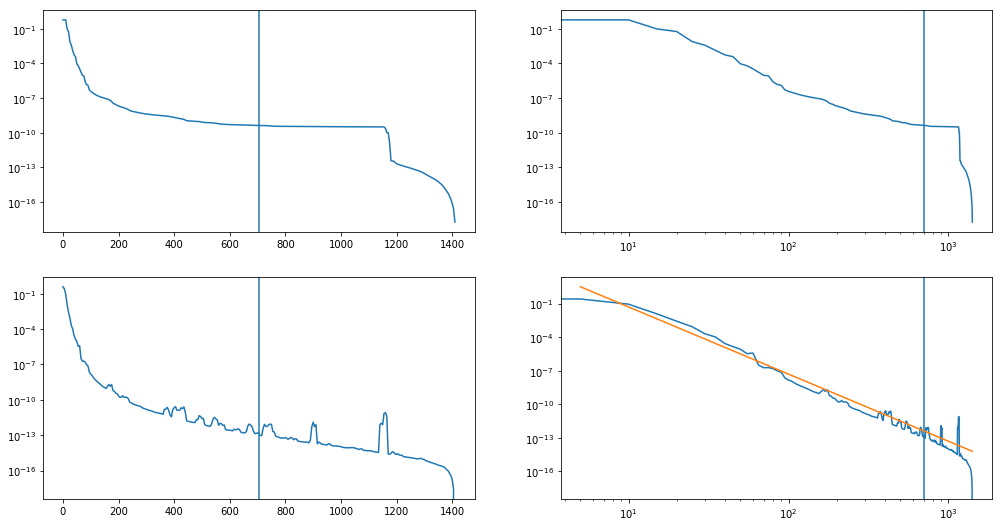

In [58]:
x=np.arange(0,float(radius*2),dr_corr)

fig, ax = plt.subplots(2,2, figsize=(17,9))


ax[0,0].plot(x, correlation)
ax[0,0].set_yscale("log")
ax[0,0].axvline(x=radius, ymin=10**-5, ymax=1)
#ax[0,0].plot(x,50000*x**-6)

ax[0,1].plot(x, correlation)
ax[0,1].set_yscale("log")
ax[0,1].set_xscale("log")
ax[0,1].axvline(x=radius, ymin=10**-5, ymax=1)
#ax[0,1].plot(x,50000*x**-6)

ax[1,0].plot(x, density)
ax[1,0].set_yscale("log")
ax[1,0].axvline(x=radius, ymin=10**-5, ymax=1)
#ax[1,0].plot(x,50000*x**-6)

ax[1,1].plot(x, density)
ax[1,1].set_yscale("log")
ax[1,1].set_xscale("log")
ax[1,1].axvline(x=radius, ymin=10**-5, ymax=1)
ax[1,1].plot(x,50000*x**-6)

In [59]:
number_atoms=1000
dens=0.25
radius=316

data = open("files/infinity/density_"+str(np.round(dens,3))+"/eigenstates/eig_"+str(number_atoms)+"_"+str(int(radius))+".npy","rb")
ratio_all       = np.load(data)   
eigenvalues_all = np.load(data)    
ipr_2_all       = np.load(data)       
density         = np.load(data) 
correlation     = np.load(data) 

density_S       = np.load(data) 
correlation_S   = np.load(data) 

print(len(eigenvalues_all))

1000000


/home/jp/.local/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in power


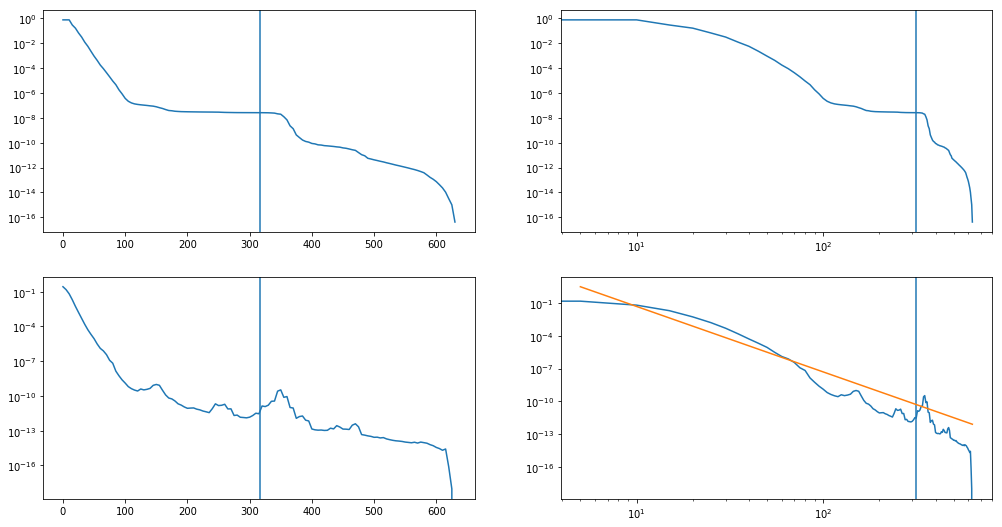

In [60]:
x=np.arange(0,float(radius*2),dr_corr)

fig, ax = plt.subplots(2,2, figsize=(17,9))


ax[0,0].plot(x, correlation)
ax[0,0].set_yscale("log")
ax[0,0].axvline(x=radius, ymin=10**-5, ymax=1)
#ax[0,0].plot(x,50000*x**-6)

ax[0,1].plot(x, correlation)
ax[0,1].set_yscale("log")
ax[0,1].set_xscale("log")
ax[0,1].axvline(x=radius, ymin=10**-5, ymax=1)
#ax[0,1].plot(x,50000*x**-6)

ax[1,0].plot(x, density)
ax[1,0].set_yscale("log")
ax[1,0].axvline(x=radius, ymin=10**-5, ymax=1)
#ax[1,0].plot(x,50000*x**-6)

ax[1,1].plot(x, density)
ax[1,1].set_yscale("log")
ax[1,1].set_xscale("log")
ax[1,1].axvline(x=radius, ymin=10**-5, ymax=1)
ax[1,1].plot(x,50000*x**-6)

In [61]:
number_atoms=1000
dens=0.45
radius=235

data = open("files/infinity/density_"+str(np.round(dens,3))+"/eigenstates/eig_"+str(number_atoms)+"_"+str(int(radius))+".npy","rb")
ratio_all       = np.load(data)   
eigenvalues_all = np.load(data)    
ipr_2_all       = np.load(data)       
density         = np.load(data) 
correlation     = np.load(data) 

density_S       = np.load(data) 
correlation_S   = np.load(data) 

print(len(eigenvalues_all))

100000


/home/jp/.local/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in power


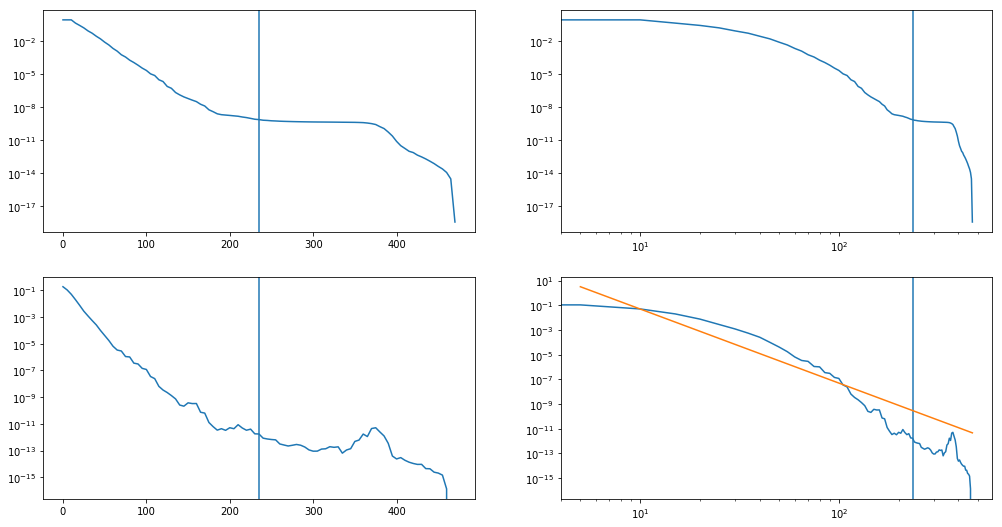

In [62]:
x=np.arange(0,float(236*2),dr_corr)

fig, ax = plt.subplots(2,2, figsize=(17,9))


ax[0,0].plot(x, correlation)
ax[0,0].set_yscale("log")
ax[0,0].axvline(x=radius, ymin=10**-5, ymax=1)
#ax[0,0].plot(x,50000*x**-6)

ax[0,1].plot(x, correlation)
ax[0,1].set_yscale("log")
ax[0,1].set_xscale("log")
ax[0,1].axvline(x=radius, ymin=10**-5, ymax=1)
#ax[0,1].plot(x,50000*x**-6)

ax[1,0].plot(x, density)
ax[1,0].set_yscale("log")
ax[1,0].axvline(x=radius, ymin=10**-5, ymax=1)
#ax[1,0].plot(x,50000*x**-6)

ax[1,1].plot(x, density)
ax[1,1].set_yscale("log")
ax[1,1].set_xscale("log")
ax[1,1].axvline(x=radius, ymin=10**-5, ymax=1)
ax[1,1].plot(x,50000*x**-6)